In [5]:
import re
import os
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# with open('../rfu_to_dilution.pkl','rb') as f:
#     rfu30_to_dilution = pickle.load(f)
#     f.close()

rfu30_to_dilution = cal.run()

In [6]:
plate1_path = '../experiment_data/max_death_rate_10122023/plate1'
plate2_path = '../experiment_data/max_death_rate_10122023/plate2'

drug_conc = [0,10,100,1000] # x MIC
drug_conc = np.array(drug_conc)*0.1

# Key refers to the genotype
plate_layout = {1:(1,['B','C','D']),2:(1,['E','F','G']),
                4:(2,['B','C','D'])} # first index is plate number, second index is list of rows

sample_time = [0,15,30,45,66,95,130,190,250,310]

In [7]:
def get_timeseries(plate_path):
    plate_files = os.listdir(plate_path)
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)
    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~':
            path_t = os.getcwd() + os.sep + plate_path + os.sep + plate_file
            p = AutoRate.Plate(path_t,mode='single_measurement')
            plates.append(p)
            data.append(p.od_data_to_dict(p.data))
    return plates,data

plates1,data1 = get_timeseries(plate1_path)
plates2,data2 = get_timeseries(plate2_path)

data = (data1,data2)

In [9]:
timeseries_dict = {}
mean_dict = {}
err_dict = {}

cell_count_dict = {}
cell_count_err_dict = {}

for key in plate_layout:
    plate_num = plate_layout[key][0]
    rows = plate_layout[key][1]
    data_t = np.zeros((len(rows),len(sample_time)))
    row_indx = 0
    for row in rows:
        col_indx = 0
        for col_num in range(len(sample_time)):
            col_num_str = str(col_num + 2) # account for plate indexing
            key_t = row + col_num_str
            data_t[row_indx,col_indx] = data[plate_num-1][col_indx][key_t]
            col_indx += 1
        row_indx += 1
    timeseries_dict[key] = data_t
    mean_dict[key] = np.mean(data_t,axis=0)
    err_dict[key] = np.std(data_t,axis=0)/np.sqrt(len(rows))

    cell_count_t = rfu30_to_dilution(data_t)
    cell_count_dict[key] = np.mean(cell_count_t,axis=0)
    cell_count_err_dict[key] = np.std(cell_count_t,axis=0)/np.sqrt(len(rows))

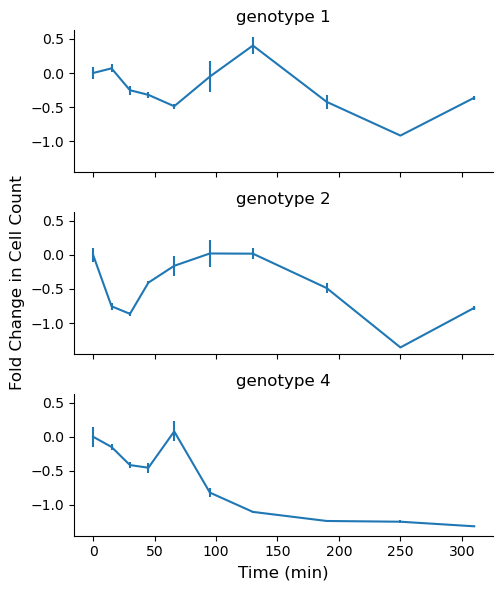

In [29]:
fig,ax_list = plt.subplots(nrows=3,figsize=(5,6),sharex=True,sharey=True)

indx = 0
for key in mean_dict:
    y = cell_count_dict[key]
    # y = y[1:]
    y = y-y[0]
    x = sample_time
    yerr = cell_count_err_dict[key]
    ax = ax_list[indx]
    ax.errorbar(x,y,yerr=yerr,label=str(key))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('genotype ' + str(key))
    # ax.set_ylabel('Fold Change in Cell Count',fontsize=12)
    indx += 1

ax_list[1].set_ylabel('Fold Change in Cell Count',fontsize=12)

ax.set_xlabel('Time (min)',fontsize=12)

# ax.set_title('Cell Count Data')
# ax.set_ylabel('Fold Change in Cell Count',fontsize=14)
# ax.legend(frameon=False)

# ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
fig.tight_layout()